# A Scenario-based Vehicle Mobility and DrivingPattern Dataset

In [337]:
import json
import csv
import glob
import cv2
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,ShuffleSplit
from sklearn.model_selection import LeaveOneOut
import os
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
from collections import OrderedDict
import datetime
from tempfile import NamedTemporaryFile
import shutil
import csv
import matplotlib.pyplot as plt    
from pandas.tools.plotting import table  
    
    
  


In [2]:
headers=["timestamp", "name", "value"]
files = glob.glob("./log/*.trace")
for names in files:
    with open(names+'_tracedata.csv', 'w') as myFile:
            writer =csv.writer(myFile)
            ll=[]
            ll.append(headers)
            writer.writerows(ll)

In [3]:

i=0
for trace in files:
    f = open(trace)
    with open(trace+'_tracedata.csv', 'a') as myFile:
        for l in f:
            if l.strip('\r\n')=="":
               continue                      
            dump_data = json.dumps(l)
            f_json= json.loads(l)
            data=[]
            data.append(round(f_json["timestamp"]))
            data.append(f_json["name"])
            data.append(f_json["value"])
            writer =csv.writer(myFile)
            
            ll=[]
            ll.append(data)
            writer.writerows(ll)
            i+=1

            




In [423]:
def svmModel(train_x,train_y):
        X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3,shuffle=True, random_state=0)
        svc = SVC(kernel='poly')
      
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
        ss=cross_val_score(svc, train_x, train_y, cv=cv)
        print(ss)
        print("Accuracy: %0.2f (+/- %0.2f)" % (ss.mean(), ss.std() * 2))
        accuracy=round(svc.score(X_test, y_test), 4)
        print('Test Accuracy of SVC = ', accuracy)
        y_pred = svc.predict(X_test)
        labels = {' b':'Hard Brake',' l': 'Left Turn',' ll': 'Shift to Left Lane', ' lr':'Shift to Right Lane',' r':'Right Turn',' u': 'U Turn'}
        var_y_test=[]
        var_y_pred=[]

        for tes in y_test:
            var_y_test.append(labels[tes])
        for tes in y_pred:
            var_y_pred.append(labels[tes])

        lab = ['Hard Brake', 'Left Turn', 'Shift to Left Lane', 'Shift to Right Lane','Right Turn','U Turn']
        sensitivity=classification_report(var_y_test, var_y_pred)
        cm=confusion_matrix(var_y_test, var_y_pred, lab)
       
        print(sensitivity)    

        
        
        
        return cm,accuracy,sensitivity

In [424]:
def random_forest(train_x, train_y):
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2,shuffle=True, random_state=0)
    
    clf = RandomForestClassifier(max_depth=6, random_state=0)
    t=time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train random forest...')
    accuracy = round(clf.score(X_test, y_test), 4)
    print('Test Accuracy of Random Forest = ', accuracy)
    y_pred = clf.predict(X_test)
    label = {' b':'Hard Brake',' l': 'Left Turn',' ll': 'Shift to Left Lane', ' lr':'Shift to Right Lane',' r':'Right Turn',' u': 'U Turn'}
    var_y_test=[]
    var_y_pred=[]

    for tes in y_test:
        var_y_test.append(label[tes])
    for tes in y_pred:
        var_y_pred.append(label[tes])
    sensitivity=classification_report(var_y_test, var_y_pred)
   
    lab = ['Hard Brake', 'Left Turn', 'Shift to Left Lane', 'Shift to Right Lane','Right Turn','U Turn']
    
    cm=confusion_matrix(var_y_test, var_y_pred, lab)
       
    print(sensitivity)    
    return cm,accuracy,sensitivity

In [227]:
files = glob.glob('./newlog/gps/*.csv')
for filename in files:

    tempfile = NamedTemporaryFile(mode='w', delete=False)

    fields = ['type', 'time', 'latitude', 'longitude','altitude (m)','speed (km/h)','course','distance (km)','distance_interval (m)','color','name','desc']

    with open(filename, 'r') as csvfile, tempfile:
        reader = csv.DictReader(csvfile, fieldnames=fields)
        writer = csv.DictWriter(tempfile, fieldnames=fields)
        i=0
        for row in reader:
            if i==0:
                row = {'type': row['type'], 'time': row['time'], 'latitude': row['latitude'], 'longitude': row['longitude'], 'altitude (m)': row['altitude (m)'], 'speed (km/h)': row['speed (km/h)'], 'course': row['course'], 'distance (km)': row['distance (km)'], 'distance_interval (m)': row['distance_interval (m)'], 'color': row['color'], 'name': row['name'], 'desc': row['desc']}
                writer.writerow(row)
                i=i+1
                continue
            
            if filename.startswith('./newlog/gps/Track_03') or filename.startswith('./newlog/gps/Track_28'):
                t=datetime.datetime.strptime(row['time'].strip(),'%Y-%m-%d %H:%M:%S')- datetime.timedelta(minutes=240)
            else:
                t=datetime.datetime.strptime(row['time'].strip(),'%Y-%m-%d %H:%M:%S')- datetime.timedelta(minutes=300)
                
            tim =t.strftime('%m-%d-%Y %H:%M:%S %s').split(" ")[2]
            row = {'type': row['type'], 'time': tim, 'latitude': row['latitude'], 'longitude': row['longitude'], 'altitude (m)': row['altitude (m)'], 'speed (km/h)': row['speed (km/h)'], 'course': row['course'], 'distance (km)': row['distance (km)'], 'distance_interval (m)': row['distance_interval (m)'], 'color': row['color'], 'name': row['name'], 'desc': row['desc']}
            writer.writerow(row)

    shutil.move(tempfile.name, filename)

In [ ]:
files = glob.glob('./newlog/newtrce/*.csv')
for filename in files:
    

    tempfile = NamedTemporaryFile(mode='w', delete=False)

    fields = ['timestamp', 'name', 'value']

    with open(filename, 'r') as csvfile, tempfile:
        reader = csv.DictReader(csvfile, fieldnames=fields)
        writer = csv.DictWriter(tempfile, fieldnames=fields)
        i=0
        for row in reader:
            if i==0:
                row = {'timestamp': row['timestamp'], 'name': row['name'], 'value': row['value']}
                writer.writerow(row)
                i=i+1
                continue
            
            t=datetime.datetime.strptime(row['time'].strip(),'%Y-%m-%d %H:%M:%S')- datetime.timedelta(minutes=300)
                
            tim =t.strftime('%m-%d-%Y %H:%M:%S %s').split(" ")[2]
            row = {'type': row['type'], 'time': tim, 'latitude': row['latitude'], 'longitude': row['longitude'], 'altitude (m)': row['altitude (m)'], 'speed (km/h)': row['speed (km/h)'], 'course': row['course'], 'distance (km)': row['distance (km)'], 'distance_interval (m)': row['distance_interval (m)'], 'color': row['color'], 'name': row['name'], 'desc': row['desc']}
            writer.writerow(row)

    shutil.move(tempfile.name, filename)

In [261]:
import numpy
import pandas
from matplotlib import pyplot
import scipy.interpolate

def pandas_interpolate(filename,df,t1,t2,method='cubic'):
    print(df.index.max())
    #df = df.reindex(np.linspace(df.index.min(),df.index.max(),num=t2-t1,endpoint=False))
    df = df.reindex(np.arange(df.index.min(),df.index.max(),round(df.index.max()/(10*(t2-t1)),2)))
    df.to_csv('sdsd.csv')
    df = df.interpolate(method=method)
    df = df.reset_index()
    df = df.rename(columns={'index': 'interp_column'})
    df.to_csv("./newlog/newgps/"+filename+"_gps.csv")
    return df

In [262]:
gps_files=glob.glob("./newlog/gps/*.csv")

for gps in gps_files:
    
    lname=gps[len("./newlog/gps/"):gps.index("_gps")]
    lbl_file="./newlog/lbl_clean/"+lname+".csv"
    df1=pd.read_csv(lbl_file)
    t1=df1['stamp'][0]
    t2=df1['stamp'][df1.shape[0]-1]
    
    ll = numpy.arange(t1, t2, (t2-t1)/df.shape[0])
    a=np.array(ll,dtype=float)
    ll=a.tolist()
    df['interp_column']=ll

    df.to_csv("accs.csv")
    df = pd.read_csv(gps)

    pandas_interpolate(lname,df,t1,t2)



680
646
243
178
188
474
110
565


In [275]:
lbl_files=glob.glob("./newlog/lbl_clean/*.csv")
final_dic=={}#OrderedDict()
for lb in lbl_files:
    df = pd.read_csv(lb)
    t1=df['stamp'][0]
    
    #t2=df.index.max()
    lname=lb[len("./newlog/lbl_clean/"):lb.index(".csv")]
    gps_file="./newlog/newgps/"+lname+"_gps.csv"
    df_gps=pd.read_csv(gps_file)
    stamps=df['stamp'].tolist()
    latitude=df_gps['latitude'].tolist()
    longitude=df_gps['longitude'].tolist()
    latitude=latitude[0:np.argwhere(np.isnan(latitude))[0][0]]
    longitude=longitude[0:np.argwhere(np.isnan(longitude))[0][0]]
    
    j=0
    
    for i in range(0,len(latitude)-10,10):
        lan=latitude[i:i+10]
        lon=longitude[i:i+10]
        dic=OrderedDict()
        dic['latitude']=lan
        dic['longitude']=lon
        final_dic[t1+j]=dic
        j=j+1
    
        
    
    

In [280]:
df_gps = pd.DataFrame(columns=['stamp','latitude', 'longitude'])
i=0
for k in final_dic.keys():
    df_temp = pd.DataFrame(columns=['stamp','latitude', 'longitude'])
    s=[]
    s.append(k)
    s=s*10
    latitude=final_dic[k]['latitude']
    longitude=final_dic[k]['longitude']
    if i==0:
        print(k)
    if i==len(final_dic.keys())-1:
        print(k)
    i+=1
    df_temp['stamp']=s
    df_temp['latitude']=latitude
    df_temp['longitude']=longitude
    frame = [df_gps, df_temp]
    df_gps = pd.concat(frame)

df_gps=df_gps.reset_index()
df_gps.to_csv('gpsss.csv',sep=',')

1541352574
1541360184


In [281]:
trainX=[]
trainY=[]
os.chdir('/home/rajat/PycharmProjects/mlproject/')
filenames=glob.glob("./newlog/lbl_clean/*.csv")

for fname in filenames:
    with open(fname) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:

            feature_keys=OrderedDict()
            feature_keys["engine_speed"]=[]
            feature_keys["fuel_consumed_since_restart"]=[]
            feature_keys["odometer"]=[]
            feature_keys["accelerator_pedal_position"]=[]
            feature_keys["torque_at_transmission"]=[]
            feature_keys["steering_wheel_angle"]=[]
            feature_keys["vehicle_speed"]=[]
            feature_keys["fuel_level"]=[]
            feature_keys["latitude"]=[]
            feature_keys["longitude"]=[]
                
            
            label=""
            if line_count == 0:
                line_count += 1
            else:
                stamp=row[3]
                label=row[4]
                if label.strip()=="" or label.strip()=="exit" or label.strip()=="ls" or label.strip()=="s" or label.strip()=="is"or label.strip()=="e":
                    continue
                
                df = pd.read_csv("./newlog/"+fname[19:len(fname)-4]+"_trace.csv")

                stamps=[int(stamp)-10,int(stamp)-9,int(stamp)-8,int(stamp)-7,int(stamp)-6,int(stamp)-5,int(stamp)-4,int(stamp)-3,int(stamp)-2,int(stamp)-1,int(stamp),int(stamp)+1,int(stamp)+2,int(stamp)+3,int(stamp)+4,int(stamp)+5,int(stamp)+6,int(stamp)+7,int(stamp)+8,int(stamp)+9,int(stamp)+10]
                for s in stamps:
                
                    for k in feature_keys.keys():
                        if k=='latitude':
                            continue
                        if k=='longitude':
                            continue
                        
                        ind1=df.index[df['timestamp'] == s].tolist()
                        if ind1==[]:
                            #print("list found empty",fname,s)
                            continue
                        ind2=df.index[df['name']==k].tolist()
                        common_index=list(set(ind1).intersection(set(ind2)))
                        values=df.loc[common_index]['value']
                        results = list(map(float, values.tolist()))
                        feature_keys[k]=feature_keys[k]+results
                       
                    if s in final_dic.keys():
                        #print("y")
                        dic=final_dic[int(s)]
                        
                        feature_keys["latitude"]=feature_keys["latitude"]+dic['latitude']
                        feature_keys["longitude"]=feature_keys["longitude"]+dic['longitude']
#                         print(feature_keys["latitude"])
#                         print(len(feature_keys["latitude"]))
#                print(len(feature_keys['latitude']))
                        
            if not label=="":
                trainX.append(feature_keys)
                trainY.append(label)
                
                  
print(len(trainX))                  

            
    

list found empty ./newlog/lbl_clean/nov_3_lbl_1_sep.csv 1541279757
list found empty ./newlog/lbl_clean/nov_3_lbl_1_sep.csv 1541279757
list found empty ./newlog/lbl_clean/nov_3_lbl_1_sep.csv 1541279757
list found empty ./newlog/lbl_clean/nov_3_lbl_1_sep.csv 1541279757
list found empty ./newlog/lbl_clean/nov_3_lbl_1_sep.csv 1541279757
list found empty ./newlog/lbl_clean/nov_3_lbl_1_sep.csv 1541279757
list found empty ./newlog/lbl_clean/nov_3_lbl_1_sep.csv 1541279757
list found empty ./newlog/lbl_clean/nov_3_lbl_1_sep.csv 1541279757
452


In [282]:
train_x=[]
max=0
for td in trainX:
    
    for k,v in td.items():
        if max<len(v):
            max=len(v)
for td in trainX:
    for k,v in td.items():
        while len(v)<max:
            v.append(0.0)
            td[k]=v
    train_x.append(td)
        
    
            

In [283]:
f_train_x=[]
for t in train_x:
    tf=[]
    for k,v in t.items():
            tf.append(v)
    f_train_x.append(tf)
final_train=np.asarray(f_train_x)
final_train1=final_train.reshape((452,final_train.shape[1]*final_train.shape[2]))

In [464]:
cm,acc,senR=random_forest(final_train1,trainY)
print("               Classification Report for SVM Model")

0.04 Seconds to train random forest...
Test Accuracy of Random Forest =  0.8791
                     precision    recall  f1-score   support

         Hard Brake       0.77      1.00      0.87        10
          Left Turn       0.79      0.85      0.81        13
         Right Turn       0.92      0.86      0.89        14
 Shift to Left Lane       0.90      0.90      0.90        20
Shift to Right Lane       0.94      0.89      0.92        19
             U Turn       0.92      0.80      0.86        15

        avg / total       0.89      0.88      0.88        91

               Classification Report for SVM Model


In [466]:
cm,acc,senS=svmModel(final_train1,trainY)
print("               Classification Report for SVM Model")

[0.65 0.69 0.64 0.7  0.66]
Accuracy: 0.67 (+/- 0.05)
Test Accuracy of SVC =  0.6691
                     precision    recall  f1-score   support

         Hard Brake       0.75      1.00      0.86        18
          Left Turn       0.72      0.59      0.65        22
         Right Turn       0.94      0.80      0.86        20
 Shift to Left Lane       0.57      0.65      0.61        31
Shift to Right Lane       0.45      0.43      0.44        23
             U Turn       0.70      0.64      0.67        22

        avg / total       0.67      0.67      0.67       136

               Classification Report for SVM Model


In [288]:
import shutil

def list_to_ds(lbl_dict, x, y, path):
    count = {g:0 for g in lbl_dict.keys()}
    for i in range (len(x)):
        dt = x[i]
        df = pd.DataFrame(dt)       
        l = lbl_dict[y[i]]
        fldr = path+l #curr_path + label_folder
        count[y[i]] += 1 #count up label folder
        no_folder = path+"/"+l+"/"+str(count[y[i]]) #path for csv to go
        
        os.mkdir(no_folder) #make directory 
        
        
        
        
        file = no_folder+"/"+str(count[y[i]])+".csv"
        df.to_csv(file, sep=',', index=False)
        
    return count


os.chdir('/home/rajat/PycharmProjects/mlproject/')
shutil.rmtree('/home/rajat/PycharmProjects/mlproject/Dataset',  ignore_errors=True)
os.mkdir('Dataset')
os.chdir('./Dataset')
path = os.getcwd()
lbl = np.unique(np.array(trainY))
lbl_dict = {'':'emp',' b':'hard_brake', ' l':'left_turn', ' ll':'left_lane', ' lr':'right_lane', ' r':'right_turn', ' u':'u_turn'}
for l in lbl:
    if l == ' b':
        os.mkdir('./hard_brake')
        
    elif l == ' l':
        os.mkdir('./left_turn')
        
    elif l == ' ll':
        os.mkdir('./left_lane')
        
    elif l == ' lr':
        os.mkdir('./right_lane')
        
    elif l == ' r':
        os.mkdir('./right_turn')
        
    elif l == ' u':
        os.mkdir('./u_turn')
        
    else:
        os.mkdir('./empty')
        

count  = list_to_ds(lbl_dict, train_x, trainY, path)

print(count)

{'': 0, ' b': 61, ' l': 75, ' ll': 97, ' lr': 79, ' r': 78, ' u': 62}


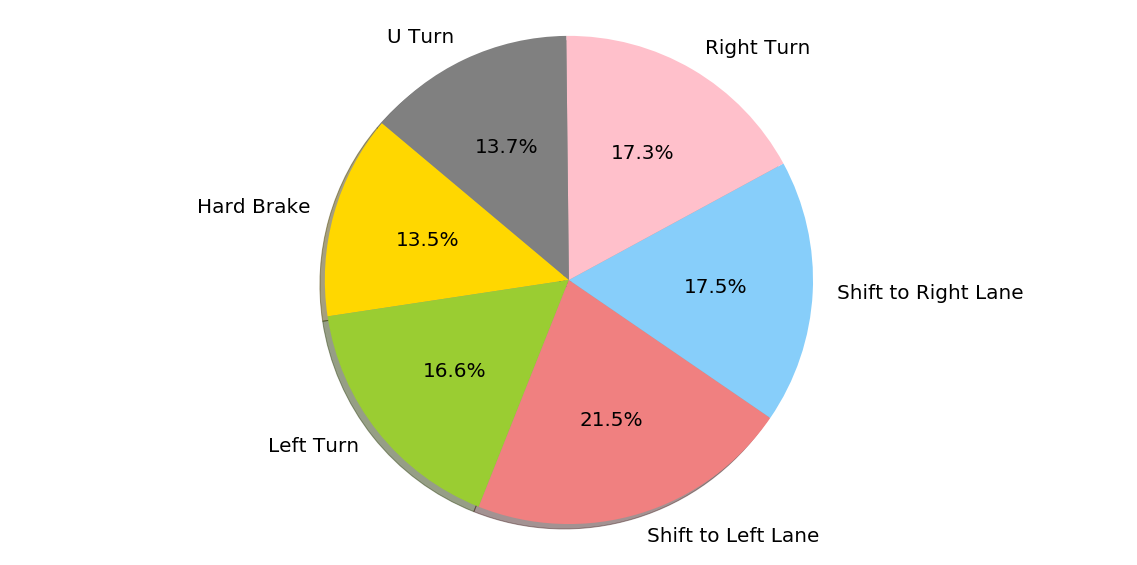

In [420]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 20.0

labels = 'Hard Brake', 'Left Turn', 'Shift to Left Lane', 'Shift to Right Lane','Right Turn','U Turn'
sizes = [count[' b'], count[' l'], count[' ll'],count[' lr'],count[' r'],count[' u']]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','pink','gray']
explode = (0, 0, 0, 0,0,0)  # explode 1st slice
 
# Plot
plt.figure(figsize=(20,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.savefig('maneuvers.png',dpi=200)
plt.show()

In [255]:
trainX[63]

OrderedDict([('engine_speed',
              [1496.0,
               1484.0,
               1486.0,
               1502.0,
               1486.0,
               1496.0,
               1478.0,
               1512.0,
               1494.0,
               1482.0,
               1474.0,
               1472.0,
               1480.0,
               1484.0,
               1480.0,
               1468.0,
               1482.0,
               1488.0,
               1472.0,
               1468.0,
               1486.0,
               1496.0,
               1508.0,
               1488.0,
               1512.0,
               1502.0,
               1486.0,
               1500.0,
               1496.0,
               1512.0,
               1558.0,
               1542.0,
               1508.0,
               1544.0,
               1522.0,
               1552.0,
               1510.0,
               1528.0,
               1562.0,
               1516.0,
               1572.0,
               1576.0,
    

Normalized confusion matrix


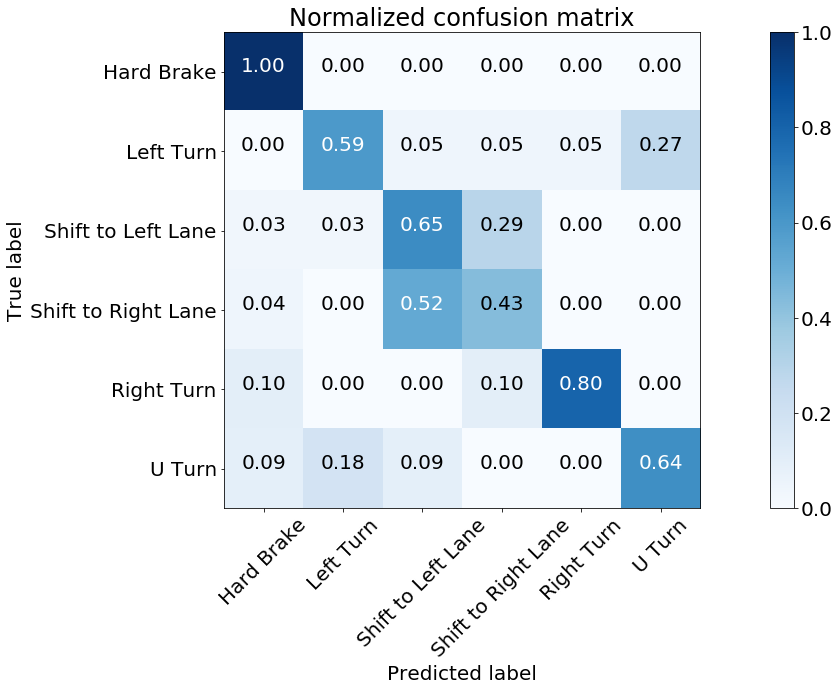

In [467]:

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
class_names = ['Hard Brake', 'Left Turn', 'Shift to Left Lane', 'Shift to Right Lane','Right Turn','U Turn']


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cm, classes=class_names,
#                       title='Confusion matrix, without normalization')
plt.figure(figsize=(20,10))

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('cm_svm.png',dpi=200)

plt.show()

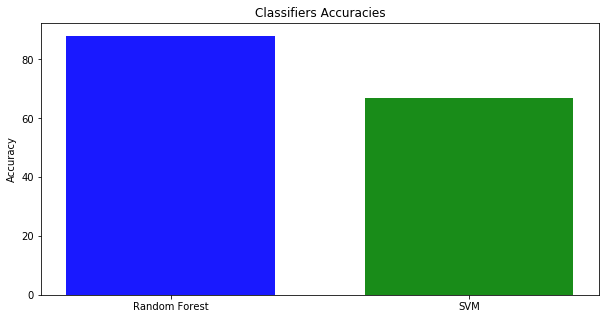

In [418]:
objects = ('Random Forest', 'SVM')
y_pos = np.arange(len(objects))
performance = [88,67]
width=0.7
plt.figure(figsize=(10,5)) 
plt.bar(y_pos, performance,width, align='center',color=['b','g'], alpha=0.90)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Classifiers Accuracies')
plt.savefig('barAcc.png')


plt.show()

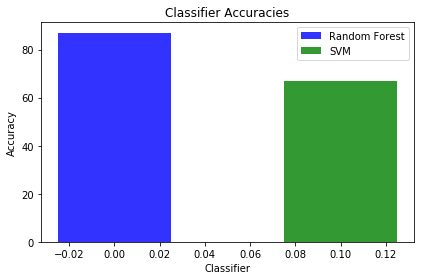

In [390]:
# data to plot
n_groups = 2
means_frank = (87)
means_guido = (67)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.05
opacity = 0.8
 
rects1 = plt.bar(0, means_frank, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Random Forest')
 
rects2 = plt.bar(0.05+bar_width, means_guido, bar_width,
                 alpha=opacity,
                 color='g',
                 label='SVM')
 
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracies')

plt.legend()
 
plt.tight_layout()
plt.show()

In [455]:
def classification_report_csv(name,report):
    report_data = []
    lines = report.split('\n')
    print(lines)
    for line in lines[2:-3]:
        print(line)
        row = {}
        row_data = line.strip().split('      ')

        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)

    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(name, index = False)

In [456]:
classification_report_csv("cllasificationReportRandom.csv",senR)
#

['                     precision    recall  f1-score   support', '', '         Hard Brake       0.77      1.00      0.87        10', '          Left Turn       0.79      0.85      0.81        13', '         Right Turn       0.92      0.86      0.89        14', ' Shift to Left Lane       0.90      0.90      0.90        20', 'Shift to Right Lane       0.94      0.89      0.92        19', '             U Turn       0.92      0.80      0.86        15', '', '        avg / total       0.89      0.88      0.88        91', '']
         Hard Brake       0.77      1.00      0.87        10
          Left Turn       0.79      0.85      0.81        13
         Right Turn       0.92      0.86      0.89        14
 Shift to Left Lane       0.90      0.90      0.90        20
Shift to Right Lane       0.94      0.89      0.92        19
             U Turn       0.92      0.80      0.86        15


TypeError: list indices must be integers or slices, not tuple

In [446]:
classification_report_csv("cllasificationReportSVM.csv",senS)

         Hard Brake       0.75      1.00      0.86        18
          Left Turn       0.72      0.59      0.65        22
         Right Turn       0.94      0.80      0.86        20
 Shift to Left Lane       0.57      0.65      0.61        31
Shift to Right Lane       0.45      0.43      0.44        23
             U Turn       0.70      0.64      0.67        22


In [ ]:
# uturn 53 left 5

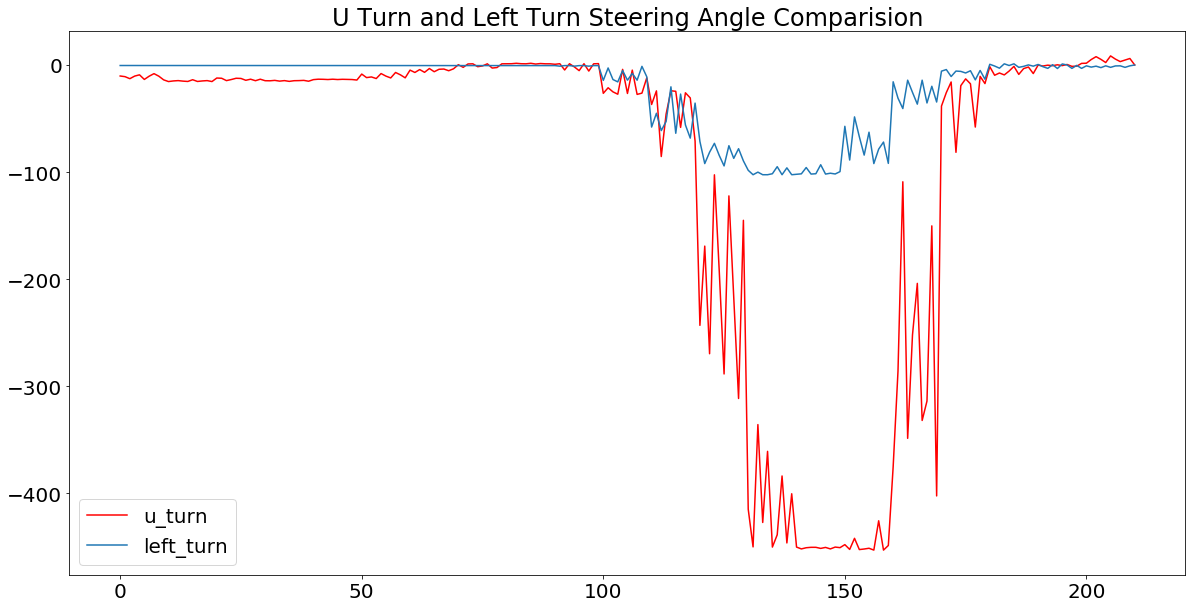

In [463]:
df = pd.read_csv("/home/rajat/PycharmProjects/mlproject/Dataset/u_turn/53/53.csv")
df1 = pd.read_csv("/home/rajat/PycharmProjects/mlproject/Dataset/left_turn/5/5.csv")

plt.figure(figsize=(20,10))
plt.plot(df['steering_wheel_angle'],'r',label='u_turn')
plt.plot(df1['steering_wheel_angle'],label='left_turn')
plt.title("U Turn and Left Turn Steering Angle Comparision")
plt.legend()
plt.savefig('ulcmp.png',dpi=200)
plt.show()




